## 이번 강의 목표: 

* 데이터 정제(data cleaning)의 필요성과 간단한 정제 방법 이해




* 생성모델의 한 예인 **나이브 베이즈 분류기(Naive Bayesian classifier)** 의 알고리즘 이해와 구현 




* 학습 모델의 성능을 평가하는 기준의 선정에 대한 이해 (분류문제의 성능을 평가하는 방법에 대해 다음 시간에 공부)

## 데이터 정제
: 훈련데이터에 에러, 이상치(outlier) 등이 있으면 기계학습 시스템이 내재된 패턴을 찾기 힘들기 때문에 적절한 작업이 필요  
>- 일부 샘플에 특성 몇 개가 빠져있으면, 이 특성을 무시할 지, 이 샘플을 무시할 지, 빠진 값을 (평균값 등으로) 채워 넣을지를 결정. 경우에 따라서는 이들을 제거한 모델과 적절하게 채워넣은 모델을 각각 훈련시켜 비교  
>> 훈련 데이터셋을 pandas의 DataFrame으로 처리하는 경우 (`ML2020-02-01-기계학습 실습 환경 및 pandas 사용법` 참고)
>>>- 빠진 샘플 확인: `isnull()` 메소드를 이용
>>>- 빠진 샘플 채우기: `fillna()` 메소드를 이용
>>>- 빠진 샘플 삭제: `dropna()` 메소드를 이용 

>- 일부 샘플이 이상치라는 것이 명확하면 제거, 그렇지 않으면 수정 (데이터에 대한 사전 지식이 필요)
>>- 표본에 대한 다양한 통계량(표본의 몇 몇 특성을 수치화한 것)을 이용하여 판단:  
>>>- 표본평균, 표본분산, 최솟값, 최댓값, 중앙값, 표본 분위수(quantile) 등 
>>- 표본(샘플 데이터)에 대한 중앙값과 분위수, 사분위수  
>>>- $0\le q \le 1$인 $q$에 대해 $q$-분위수가 $a$라는 말은 표본 중 $a$보다 작거나 같은 표본의 비율이 $q$라는 의미 
>>>- [Pandas의 분위수 API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html?highlight=quantile#pandas.DataFrame.quantile)
>>>- 사분위수: $0.25$-분위수, $0.5$-분위수, $0.75$-분위수를 각각 제1사분위수, 제2사분위수, 제3사분위수라 하고, $Q_1,Q_2,Q_3$로 나타냄  
>>>- 사분범위(inter quantile range): 표본의 가운데 50%에 대응하는 구간 $[Q_1,Q_3]$, $\text{IQR}=Q_3-Q_1$으로 정의
>>- 참고: 모집단의 분포에 대한 [분위수 함수 설명](https://terms.naver.com/entry.nhn?docId=5669018&cid=60207&categoryId=60207) 
>>>- 중앙값과 사분범위를 이용하여 데이터의 분포를 나타내는 방법: [Pandas의 DataFrame에 대한 `plot.box()` API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.box.html?highlight=box#pandas.DataFrame.plot.box)  
>>>- `plot.box()` method와 함께 `boxplot()` method도 살펴볼 것: [Pandas의 DataFrame에 대한 `boxplot()` API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html#pandas.DataFrame.boxplot)
<img src=".\images\ML2020-04-01_box.png" width="400">
>>>- 위 그림에서 박스 위, 아래의 선은 최대 $Q3+1.5\,\text{IQR}$, 최소 $Q1-1.5\,\text{IQR}$까지 표시될 수 있으며, 실제 표본에 있는 값의 범위까지만 표시됨 (아래 <span style="color:red">**예제 코드 참고**</span>)

>- 지난 시간에 다룬 `PimaIndiansDiabetes.csv`에 대해 간단한 데이터 정제를 실습 


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### <span style="color:red">box 그림 예제 코드</span>

In [3]:
temp = pd.Series([0.1, 0.15, 0.2, 0.21, 0.25, 0.3, 0.31, 0.32, 0.35, 0.38, 0.4, 0.43, 0.6, 0.65, 0.7, 0.78, 1.125, 1.4])
len(temp)

18

In [4]:
q1,q2,q3 = temp.quantile([0.25,0.5,0.75])
print(f"Q1={q1:.3f}, Q2={q2:.3f}, Q3={q3:.3f}")
print(f"IQR={q3-q1:.3f}, whisker upper bound={q3+1.5*(q3-q1) :.3f}, whisker lower bound={q1-1.5*(q3-q1) :.3f}")

Q1=0.263, Q2=0.365, Q3=0.638
IQR=0.375, whisker upper bound=1.200, whisker lower bound=-0.300


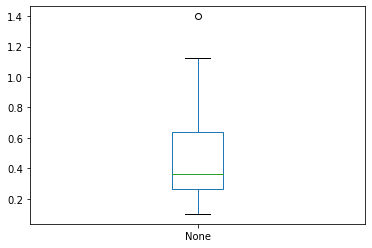

In [5]:
temp.plot.box()

#### PimaIndiansDiabetes.csv 데이터셋에 대한 데이터 정제 실습 

In [6]:
data = pd.read_csv('./datasets/PimaIndiansDiabetes.csv')
data_subset = data.loc[:,['Blood Glucose', 'BMI', 'Class']]

In [7]:
data_subset.quantile([0.25,0.5,0.75])

,Blood Glucose,BMI,Class
0.25,99.00,27.3,0.0
0.50,117.00,32.0,0.0
0.75,140.25,36.6,1.0


* 위 결과를 보면 레이블이 0인 샘플의 개수가 더 많은 것을 알 수 있음 

* 이상치를 파악하기 위해 box그림을 그려보면 다음과 같음 

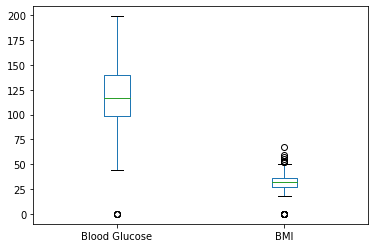

In [8]:
data_subset[['Blood Glucose', 'BMI']].plot.box()

* box 그림에서 혈당과 BMI 모두 0근처에 이상치가 보임 --> 최솟값을 구해서 확인 
> - 혈당(Blood Glucose)이나 체질량지수(BMI)값이 0이 되는 것은 불가능함  
> - 혈당과 체질량지수 모두 당뇨병 진단과 관련성이 있으므로 하나라도 0이 샘플은 삭제

In [9]:
# 각 특성에 대한 최솟값 확인 

min_values = data_subset.min()

print(min_values)

Blood Glucose    0.0
BMI              0.0
Class            0.0
dtype: float64


In [10]:
# 혈당과 체질량지수 모두 당뇨병 진단과 관련성이 있으므로 하나라도 0이 샘플은 삭제

bg_mask = data_subset.loc[:,"Blood Glucose"]!=0
bmi_mask = data_subset.loc[:,"BMI"]!=0
clean_data_subset = data_subset[bg_mask & bmi_mask]

In [11]:
print(len(data_subset))
print(len(clean_data_subset))

768
752


In [12]:
clean_data_subset.min()

Blood Glucose    44.0
BMI              18.2
Class             0.0
dtype: float64

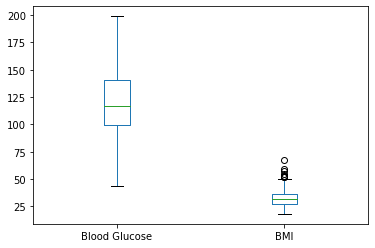

In [13]:
clean_data_subset[['Blood Glucose', 'BMI']].plot.box()

#### 정제된 데이터를 특성벡터와 레이블로 나누기 

In [14]:
X = clean_data_subset.loc[:, ['Blood Glucose', 'BMI']]
y = clean_data_subset.loc[:, 'Class']

#### 훈련 데이터셋과 테스트 데이터셋으로 나누기

* `ML2020-03-02-판별모델의 예`에서 배운 것처럼 아래와 같이 구현할 수 있음 
        
        from sklearn.model_selection import train_test_split 
        X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=20)
        
* 여기서는 `np.random.shuffle()`함수를 이용하여 구현 ([np.random.shuffle() 함수는 inplace임에 유의](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html?highlight=shuffle#numpy.random.shuffle))

* clean_data_subset은 data_subset에서 일부 샘플을 삭제한 것이므로 clean_data_subset의 행에 접근할 때는 iloc을 이용해야 함 

* `np.random.permutation()`함수를 이용하여 구현하는 것도 가능 ([API 참조](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html?highlight=permutation#numpy.random.permutation))


In [15]:
ratio = 0.8
total_num = len(clean_data_subset)
train_num = int(ratio*total_num)

np.random.seed(42)
shuffled_idx = np.arange(total_num)
np.random.shuffle(shuffled_idx)

X_train = X.iloc[shuffled_idx[:train_num]]
y_train = y.iloc[shuffled_idx[:train_num]]
X_test = X.iloc[shuffled_idx[train_num:]]
y_test = y.iloc[shuffled_idx[train_num:]]

## 생성모델의 예: (클래스 종류가 2인) 나이브 베이즈 분류기(Naive Bayesian Classifier) 

* 확률변수 $X=(X_1,\cdots,X_n)$와 $0$과 $1$ 두 값만을 취할 수 있는 $Y$의 결합확률분포를 결정하는 결합확률함수를 $p(\mathbf x,y)=p(x_1,\cdots,x_n,y)$라 하고, 이 확률분포에 대해 $m$번의 독립시행으로 즉, 독립동일분포(independent identically distribution:iid)를 따르는 $m$개의 훈련샘플 $(\mathbf x_i,y_i)\ (1\le i \le m)$을 얻었다고 하자.   

>* 이때, (동일한 분포에서 독립시행으로 얻은 샘플이므로)  $m$개의 샘플에 대한 확률함수값은 $\prod_{i=1}^m p(\mathbf x_i,y_i)= \prod_{i=1}^m p(x_{i1},\cdots,x_{in},y_i)\quad \cdots (1)$

>* $p(\mathbf x,\mathbf z)=p(\mathbf z)p(\mathbf x|\mathbf z)$를 반복하여 적용하면, (1)에서 각 $p(\mathbf x_i,y_i)$는 
$$\begin{aligned}p(\mathbf x_i,y_i)=&p(x_{i1},\cdots,x_{i(n-1)},y_i)p(x_{in}|x_{i1},\cdots,x_{i(n-1)},y_i)\\
=&p(x_{i1},\cdots,x_{i(n-2)},y_i)p(x_{i(n-1)}|x_{1i},\cdots,x_{i(n-2)},y_i)p(x_{in}|x_{i1},\cdots,x_{i(n-1)},y_i)\\
=&\cdots\\
=&p(x_{i1},y_i)p(x_{i2}|x_{i1},y_i)p(x_{i3}|x_{i1},x_{i2},y_i)\cdots p(x_{i(n-1)}|x_{1i},\cdots,x_{i(n-2)},y_i)p(x_{in}|x_{i1},\cdots,x_{i(n-1)},y_i)\\
=&p(y_i)p(x_{i1}|y_i)p(x_{i2}|x_{i1},y_i)p(x_{i3}|x_{i1},x_{i2},y_i)\cdots p(x_{i(n-1)}|x_{1i},\cdots,x_{i(n-2)},y_i)p(x_{in}|x_{i1},\cdots,x_{i(n-1)},y_i)\\
\end{aligned}$$
이고, 일반적으로 $p(x_{ik}|y_i)\neq p(x_{ik}|x_{i1},\cdots,x_{i(k-1)},y_i)$

>* 한편, $Y=y_i$가 주어진 조건하에서 $X_k$와 $X_{\ell}$이 서로 독립이 될 때 **조건부 독립(conditionally independent)**라 함. 

>* 따라서, 위 상황에서 조건부 독립을 가정하면 $p(x_{i1},\cdots,x_{in}|y_i)=\prod_{k=1}^n p(x_{ik}|y_i)$가 성립하고 이때 식 (1)은 
$\prod_{i=1}^m p(\mathbf x_i,y_i)= \prod_{i=1}^m p(x_{i1},\cdots,x_{in},y_i)=\prod_{i=1}^m\left( p(y_i)\prod_{k=1}^n p(x_{ik}|y_i)\right)\quad \cdots (2)$

>* 나이브 베이즈 분류기는 $Y$가 주어질 때 $(X_1,\cdots,X_n)$의 각 $X_i$들이  서로 조건부 독립이라고 가정하고, $p(\mathbf x,y)=p(y)\prod_{k=1}^n p(x_k|y)$를 이용하여 $p(y|\mathbf x)=\dfrac{p(\mathbf x,y)}{p(\mathbf x)}$를 계산하여 비교하는 분류기

>>* $p(\mathbf x,y)=p(y)\prod_{k=1}^n p(x_{k}|y)$를 구하기 위해서, $Y$의 확률함수 $p(y)$와 $Y=y$가 주어질 때 $X_k$의 조건부 확률함수 $p(x_k|y)\ (1\le k\le n)$을 각각 구해야 함  
>>* 가정으로부터 $Y$가 취할 수 있는 값은 $0$과 $1$이므로 $Y$는 $Y=1$일 확률이 $\theta_0$인 베르누이 분포를 따르고, 확률함수는 
$$p(y;\theta_0)=\theta_0^y(1-\theta_0)^{1-y},\quad (0\le \theta \le 1)$$ 
>>>___
>>>* 위 식 $p(y;\theta_0)$에서 `;` 뒤에 적힌 $\theta_0$는 확률변수가 아닌 모델 파라미터라는 의미

>>* 각 $k=1,\cdots,n$에 대해, 훈련 데이터셋중 $Y=y$인 샘플만을 모아서 $X_k$의 분포(즉, $\{x_{ik}:y_i=y\}$)를 분석하여 조건부 확률함수 $p(x_k|y)$를 추정 (이때 $X_k$에 대응되는 조건부 확률함수는 모델 파라미터 $\mathbf \theta_k$에 따라 결정됨)
>>>---
>>>* 예를 들어, $Y=y$가 주어질 때 $X_k$가 두 가지 값만을 갖는 이산확률변수라면, $P(X_k=1|Y=1)=\theta_{k1},\ P(X_k=1|Y=0)=\theta_{k0}$이라 할 때
$$\begin{aligned}
 &\\
p(x_k|1)=&p(x_k|1;\theta_{k1})=\theta_{k1}^{x_k}(1-\theta_{k1})^{1-x_k},\quad (0\le \theta_{k1}\le 1)\\
p(x_k|0)=&p(x_k|0;\theta_{k0})=\theta_{k0}^{x_k}(1-\theta_{k0})^{1-x_k},\quad (0\le \theta_{k0}\le 1)\\
&
\end{aligned}$$
과 같이 베르누이분포로 모델링 (이때, $\mathbf{\theta}_k=(\theta_{k0},\theta_{k1})$) 
>>>___
>>>* 예를 들어, $Y=y$가 주어질 때 $X_k$가 평균이 $\mu_{ky}$이고 분산이 $\sigma_{ky}^2$인 정규분포로 따르는 것으로 추정한다면 조건부 확률함수는 
$$
\begin{aligned}
& \\
p(x_k|1;\mu_{k1},\sigma_{k1})=&\dfrac 1{\sqrt{2\pi}\sigma_{k1}}\text{exp}\bigl(-\dfrac{(x_k-\mu_{k1})^2}{2\sigma_{k1}^2}\bigr)\\
p(x_k|0;\mu_{k0},\sigma_{k0})=&\dfrac 1{\sqrt{2\pi}\sigma_{k0}}\text{exp}\bigl(-\dfrac{(x_k-\mu_{k0})^2}{2\sigma_{k0}^2}\bigr)\\
& \\
\end{aligned}
$$
으로 둘 수 있고, 이때 모델 파라미터는 $\theta_k = (\mu_{k0},\sigma_{k0},\mu_{k1},\sigma_{k1})$   
>>___
>>* 따라서, 샘플 $(\mathbf x_i,y_i)$에 대한 결합확률함숫값 $$p(\mathbf x_i,y_i)=p(x_{i1},\cdots,x_{in},y)=p(y_i;\theta_0)\prod_{k=1}^n p(x_{ik}|y_i; \theta_k)$$은 모델 파라미터 $\theta_0,\theta_1,\cdots,\theta_n$에 대한 함수로 이해할 수 있음 
>>___
>>* 각 모델 파라미터들을 정하는 방법 중 하나는 훈련 데이터셋 $Z=\{(\mathbf x_i,y_i)|1\le i \le m\}$이 주어질 때, 식 (2)의 값이 가장 커지도록(가장 그럴듯 하도록) 모델 파라미터들을 정하는 것 (이를 **최대우도추정법(maximum likelihood estimation)**이라고 함) 
>>>* 즉, 훈련 데이터셋 $Z=\{(\mathbf x_i,y_i)|1\le i \le m\}$이 주어질 때, 식 (2)를 모델 파라미터에 대한 우도함수 $$
\begin{aligned}
&L(\theta_0,\theta_1,\cdots,\theta_n)\\
=&\prod_{i=1}^m\left(\prod_{k=1}^n p(y_i;\theta_0)p(x_k|y_k;\theta_k)\right)\quad (3)
\end{aligned}$$
로 생각하고, 이 값이 최대가 되는 $\theta_0,\cdots,\theta_n$을 구한다.
>>>___
>>>* $L(\theta_0,\cdots,\theta_n)$이 최대가 되는 모델 파라미터 $(\theta_0,\cdots,\theta_n)$을 구하는 것은 이 함수에 로그를 취한 **로그우도함수** $$\ell(\theta_0,\cdots,\theta_n)=\ln(L(\theta_0,\cdots,\theta_n))$$이 최대가 되는 모델 파라미터를 구하는 것과 동치이고, 이것은 다시 $-\ell(\theta_0,\cdots,\theta_n)$가 최소가 되는 모델 파라미터를 구하는 것과 같다.   
>>>---
>>>* 즉, 식 (3)으로부터 다음 식
$$
\begin{aligned}
&-\ell(\theta_0,\cdots,\theta_n)\\
=&-\sum_{i=1}^m\sum_{k=1}^n\bigl(\ln(p(y_i;\theta_0)+\ln(p(\mathbf x_i|y_i;\theta_1,\cdots,\theta_n)\bigr) 
\end{aligned}
$$
이 최소가 되는 모델 파라미터 $\theta_0,\cdots,\theta_n$를 구하면 되고, 
>>>___
>>* 특히, $Y$가 확률이 $\theta_0$이 베르누이 분포를 따르고, $Y=y$가 주어질 때 각 $X_k|Y=y\ (1\le k\le n)$가 정규분포 $N(\mu_{ky},\sigma_{ky}^2)$를 따르는 경우(즉, $\theta_k=(\mu_{k0},\sigma_{k0},\mu_{k1},\sigma_{k1})$), 위 식으로부터 다음 식이 최소가 되는 $\theta_0$와 $\mu_{k0},\sigma_{k0},\mu_{k1},\sigma_{k1}\ (1\le k\le n)$을 구하면 됨 
$$
\begin{aligned}
& \\
&-\ell(\theta_0,\mu_{10},\sigma_{10},\mu_{11},\sigma_{11},\cdots, \mu_{n0},\sigma_{n0},\mu_{n1},\sigma_{n1})\\
= &-\sum_{i=1}^m\sum_{k=1}^n \left(y_i\ln(\theta_0)+(1-y_i)\ln(1-\theta_0)-\dfrac 1 2\ln(2\pi)-\ln\sigma_{ky_i} -\dfrac{(x_{ik}-\mu_{ky_i})^2}{2\sigma_{ky_i}^2}\right) \\
= &-n\left(\sum_{i=1}^m y_i \ln(\theta_0)+(1-y_i)\ln(1-\theta_0)\right)\\
 & \quad +\sum_{k=1}^n\left(m_0\ln \sigma_{k0}+m_1\ln \sigma_{k1}+\dfrac{\sum_{1\le i\le m,y_i=0}(x_{ik}-\mu_{k0})^2}{2\sigma_{k0}^2}+\dfrac{\sum_{1\le i\le m,y_i=1}(x_{ik}-\mu_{k1})^2}{2\sigma_{k1}^2}\right)\\
 & \qquad+\dfrac{mn} 2 \ln(2\pi) \quad \cdots (4)\\
\end{aligned} 
$$
>>>___
>>>* 훈련 데이트셋 중 레이블이 $1$인 샘플의 개수를 $m_1$, $0$인 샘플의 개수를 $m_0$라 할 때,  
식 (4)가 최소가 되게 하는 모델 파라미터를 구하면 다음과 같음 <span style="color:red">(check 1)</span>
$$
\begin{aligned}
&\theta_0 = \dfrac{m_1}{m_0+m_1}=\dfrac{m_1}{m}\\
&\mu_{k0}=\dfrac{\sum_{1\le i\le m,y_i=0}x_{ik}}{m_0},\quad \sigma_{k0}^2 = \dfrac{\sum_{1\le i\le m,y_i=0}(x_{ik}-\mu_{k0})^2}{m_0}\quad (1\le k\le n)\quad \cdots (5)\\
&\mu_{k1}=\dfrac{\sum_{1\le i\le m,y_i=1}x_{ik}}{m_1},\quad \sigma_{k1}^2 = \dfrac{\sum_{1\le i\le m,y_i=1}(x_{ik}-\mu_{k1})^2}{m_1}\quad (1\le k\le n)
\end{aligned}
$$

>* 나이브 베이즈 모델에서 $p(\mathbf x,y)=p(y)p(\mathbf x|y)$를 구하고 나면, $p(y|\mathbf x)=\dfrac{p(\mathbf x,y)}{p(\mathbf x)}$로부터 판별함수 $\hat f(\mathbf x)$를 다음과 같이 정의함
$$
\hat f(\mathbf x)=\begin{cases} 1 & \quad \text{if }p(1)p(\mathbf x|1)\ge p(0)p(\mathbf x|0)\\
0 & \quad \text{if }p(1)p(\mathbf x|1)< p(0)p(\mathbf x|0)
\end{cases}
$$
>>* 위 식에서 $\dfrac{p(\mathbf x,0)}{p(\mathbf x)}$와 $\dfrac{p(\mathbf x,1)}{p(\mathbf x)}$를 비교할 때, $p(\mathbf x)$가 공통이므로 분자만 비교하면 됨  
>>* <span style="color:red">위 식에서 판별함수는 $p(y|\mathbf x)\ge0.5$일 때 레이블 $1$을 반환하는 함수이지만, 경우에 따라서는 $0.5$가 아닌 임곗값(threshold) $t\, (0<t<1)$을 이용하여 판별함수를 구성하는 것도 가능하다. (다음 시간에 공부하는 내용 참조)</span>  
>>>* <span style="color:red">좀 더 확실한 경우에만 레이블 $1$을 반환하려면 $t>0.5$인 값을 임곗값으로 선택. </span>
>>>* <span style="color:red">학습모델의 성능을 높이는 방법으로 임곗값을 조절하는 경우, 교차검증을 이용하여 임곗값을 정할 수 있음 (다음 시간에 공부)</span>

## PimaIndiansDiabetes.csv 데이터셋에 대한 나이브 베이즈 분류기 구현 

1) 앞에서 주어진 데이터셋을 정제하여 `clean_data_subset`을 만들고, 이를 훈련 데이터셋(X_train, y_train)과 테스트 데이터셋(X_test, y_test)로 나누어 구성했음 

2) 이제 훈련 데이터셋 X_train의 각 샘플 $(x_{i1},x_{i2})$를 레이블에 따라 구분하고, 확률함수 $p(x_1|0), p(x_1|1), p(x_2|0), p(x_2|1)$을 추정  
>2-1) 훈련 데이터셋에서 레이블이 $0$인 샘플들을 모은 데이터셋 X_train0, y_train0과 레이블이 $1$인 샘플들을 모은 데이터셋 X_train1, y_train1을 구성  

>2-2) X_train0, X_train1의 각 열에 대해 히스토그램을 그려 $p(x_1|0),\,p(x_1|1),\,p(x_2|0),\,p(x_2|1)$을 추정  
>> * DataFrame.plot.hist(bins=막대그래프 개수)를 이용하여 그릴 수 있지만, $y$축의 값이 주어진 범위에 속하는 샘플의 개수로 표시됨 
>> * plt.hist()를 이용하면 분포를 가장 잘 보여주는 bin의 개수를 계산없이 사용할 수 있음 
>>>* **Freedman-Diaconis rule**에 의해 bin의 개수를 결정: bin의 사이즈 = $\dfrac{2\, \text{IQR}}{\sqrt[3]{\text{샘플 개수}}}$  
>>>* `plt.hist(데이터, bins='fd', density=True)`와 같이 옵션 `bins`를 `fd`로 설정하면, Freedman-Diaconis rule에 의해 bin이 결정되고, $y$축의 값은 막대그래프의 전체 넓이의 합이 $1$이 되도록 조절됨 
>>>* `DataFrame(또는 Series).plot.density()`를 이용하면 주어진 데이터를 이용하여 (Gaussian) kernel density estimation 방법으로 추정한 확률함수의 그래프를 그릴 수 있음 

>2-3) 2-2)에서 추정한 확률분포 구현 
>2-4) Y_train을 이용하여 $Y$에 대한 베르누이 분포를 추정 

3) 2)에서 구한 확률함수들을 이용하여 $p(\mathbf x,0)=p(0)p(x_1|0)p(x_2|0)$와 $p(\mathbf x,1)=p(1)p(x_1|1)p(x_2|1)$을 계산 

4) 3)에서 구한 값을 비교하여 레이블을 결정하는 판별함수 구현 

5) 정확도 계산 

In [16]:
# 설명의 2-1)구현 

X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
m0 = (y_train==0).sum()
m1 = (y_train==1).sum()

In [17]:
m0

384

In [18]:
m1

217

In [19]:
print(f'number of samples in class 1:{m1}\nnumber of samples in class 0:{m0}')

number of samples in class 1:217
number of samples in class 0:384


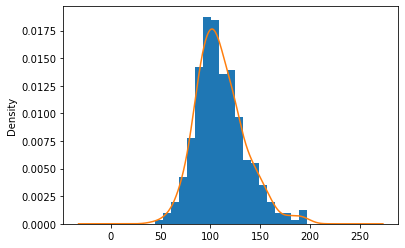

In [20]:
# 설명의 2-2)구현 
# bins = 'fd' 는 이상적으로 알아서 빈을 나눠라
plt.hist(X_train0.loc[:,'Blood Glucose'],bins='fd',density=True)
X_train0.loc[:,'Blood Glucose'].plot.density()

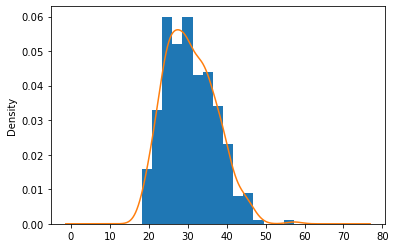

In [21]:
plt.hist(X_train0.loc[:,'BMI'],bins='fd',density=True)
X_train0.loc[:,'BMI'].plot.density()

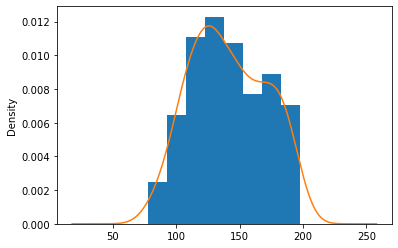

In [22]:
plt.hist(X_train1.loc[:,'Blood Glucose'],bins='fd',density=True)
X_train1.loc[:,'Blood Glucose'].plot.density()

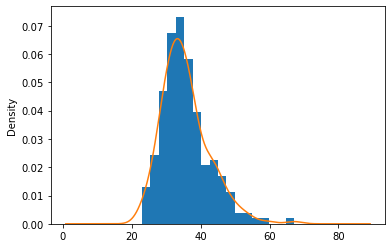

In [23]:
plt.hist(X_train1.loc[:,'BMI'],bins='fd',density=True)
X_train1.loc[:,'BMI'].plot.density()

#### 위의 히스토그램을 보면 p(Blood Glucose|1)을 제외한 분포는 정규분포와 유사 

* $p(x_1|0),\, p(x_1|1),\, p(x_2|0),\, p(x_2|1)$가 모두 정규분포라고 가정하고 식 (5)를 이용하여 확률함수를 계산  
> * 정규분포의 확률밀도함수를 구현할 수도 있지만, 앞서 익힌 `scipy.stats`의 `norm`을 이용하여 확률함수를 구현  
>> * `scipy.stats`의 `norm`을 이용하여 확률분포를 구할 때, 평균과 표준편차를 입력으로 전달해야 함 
> * 확률함수를 구하는 함수 `fit_distribution`을 구현 

* <span style="color:red">주의</span>: 식 (5)에서 $\sigma_{k0}, \, \sigma_{k1}$을 계산할 때, `np.std()`함수나 `pd.Series.std(ddof=0)` 함수를 이용해야 함 (`np.std`는 표준편차 $\sqrt{\dfrac{\sum_{i=1}^n (x_i-\mu)^2}{n}}$를 계산하고, `pd.Series.std(ddof=1)`은 표본표준편차 $\sqrt{\dfrac{\sum_{i=1}^n (x_i-\mu)^2}{n-1}}$을 계산함)

In [24]:
from scipy.stats import norm

#### 훈련 데이터를 Numpy array로 변환하여 사용

In [25]:
# 설명의 2-3)구현 

def fit_distribution(data, col_idx):
    # 식 (5)를 이용하여 정규분포의 평균과 표준편차를 추정 
    mu = data[:,col_idx].mean()
    sigma = data[:,col_idx].std(ddof=0)
    
    # 확률분포 구하기 
    dist = norm(mu, sigma)
    return dist

In [26]:
# X1: Blood Glucose, X2:BMI라 할 때, 주어진 y에 대한 X1의 조건부 확률분포, X2의 조건부 확률분포 계산 
# 훈련 데이터를 Numpy array로 
X_train0 = X_train0.to_numpy()
X_train1 = X_train1.to_numpy()

distX1y0 = fit_distribution(X_train0, 0) #'Blood Glucose'
distX2y0 = fit_distribution(X_train0, 1) #'BMI'
distX1y1 = fit_distribution(X_train1, 0) #'Blood Glucose'
distX2y1 = fit_distribution(X_train1, 1) #'BMI'

In [27]:
# 설명의 2-4)구현 

prior0 = m0/(m0+m1)
prior1 = m1/(m0+m1)

In [28]:
print(f"P(y=1)={prior1:.3f}, P(y=0)={prior0:.3f}")

P(y=1)=0.361, P(y=0)=0.639


In [56]:
# 설명의 3)구현 

def joint_prob(data, prior, distX0, distX1):
    return prior * distX0.pdf(data[:,0]) * distX1.pdf(data[:,1])

In [48]:
# 설명의 4),5)구현 

# 훈련 데이터셋에 대한 예측 
train_prob0 = joint_prob(X_train.to_numpy(), prior0, distX1y0,distX2y0)
train_prob1 = joint_prob(X_train.to_numpy(), prior1, distX1y1,distX2y1)

train_prediction = (train_prob1>train_prob0).astype(int)

# 정확도 계산
train_acc = (train_prediction == y_train).sum()/len(y_train)

print(f"훈련 데이터셋에 대한 정확도={train_acc * 100 : .1f}%")

훈련 데이터셋에 대한 정확도= 75.7%


In [68]:
p0 = distX1y0.pdf(X_test.to_numpy()[:,0]) * distX2y0.pdf(X_test.to_numpy()[:,1]) * prior0
p1 = distX1y1.pdf(X_test.to_numpy()[:,0]) * distX2y1.pdf(X_test.to_numpy()[:,1]) * prior1

In [51]:
# 테스트 데이터셋에 대한 예측 
test_prob0 = joint_prob(X_test.to_numpy(), prior0, distX1y0,distX2y0)
test_prob1 = joint_prob(X_test.to_numpy(), prior1, distX1y1,distX2y1)

test_prediction = (test_prob1>test_prob0).astype(int)

# 정확도 계산
test_acc = (test_prediction == y_test).sum()/len(y_test)

print(f"테스트 데이터셋에 대한 정확도={test_acc * 100 : .1f}%")

테스트 데이터셋에 대한 정확도= 77.5%


In [63]:
test_prediction

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

In [52]:
test_prediction

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

In [53]:
train_prediction

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,

## 앞에서 구현한 것을 Scikit-learn class형태로 구현하기: MyGaussianNB <span style="color:red">(아래 연습문제5)</span>

* 지난 시간에 공부한 `sklearn.linear_model`의 `Perceptron()` 클래스처럼  `fit()`, `predict()`, `predict_proba()`, `score()` method를  이용할 수 있도록 구현 

* 가능한 레이블은 $0$과 $1$ 두 가지 

* 구현의 편의를 위해 X_train, y_train, X_test, y_test를 모두 numpy array라고 가정하고 구현 

In [ ]:
# 입력으로 주어지는 데이터는 모두 numpy array라고 가정하고 구현 
# 입력 특성의 개수에 관계없이 동작하도록 구현 

class MyGaussianNB: 
    def __init__(self):
        self.distXy0 = []
        self.distXy1 = []
        self.prior0 = 0
        self.prior1 = 0
        self.m0 = 0 # 훈련 데이터에서 레이블이 0인 샘플 개수
        self.m1 = 0 # 훈련 데이터에서 레이블이 0인 샘플 개수
        self.num_col = 0 # 특성벡터의 차원 
        
    
    def fit(self, X_train, y_train):
        self.num_col = X_train.shape[1] 
        
        X_train0 =  ###################여기를 채우세요
        X_train1 =  ###################여기를 채우세요
        self.m0 =   ###################여기를 채우세요
        self.m1 =   ###################여기를 채우세요
        
        # self.fit_dist() method는 코드 맨 끝에 정의되어 있음 
        for i in range(self.num_col):
            self.distXy0.append(self.fit_dist(X_train0,i)) # X_train0의 column index i열에 대한 정규분포를 distXy0 리스트 i번째에 추가
            self.distXy1.append(self.fit_dist(X_train1,i)) # X_train1의 column index i열에 대한 정규분포를 distXy1 리스트 i번째에 추가
        
        self.prior0 =    ###################여기를 채우세요
        self.prior1 =    ###################여기를 채우세요
        

    def predict_proba(self, X):
        prob0 = self.prior0
        prob1 = self.prior1
        for i in range(self.num_col):
            prob0 *=     ###################여기를 채우세요
            prob1 *=     ###################여기를 채우세요
        
        result = np.array([prob0, prob1])/ (prob0+prob1)
        return result.T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return          ###################여기를 채우세요
    
    def fit_dist(self,data, col_idx):
        mu = data[:,col_idx].mean()
        sigma = data[:,col_idx].std(ddof=0)
    
        dist = norm(mu, sigma)
        return dist

#### 아래 코드를 차례로 실행시키면서 정답을 비교하여 제대로 구현되었는지 확인하세요. 

In [ ]:
# 준비된 데이터가 pd.DataFrame일 때, 모두 to_numpy() 메소드를 이용하여 numpy array로 바꾼 뒤에 사용 

ClassifierNB = MyGaussianNB()

ClassifierNB.fit(X_train.to_numpy(), y_train.to_numpy())

ClassifierNB.predict(X_test.to_numpy())[:22]

위 결과 정답 비교:  

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],dtype=int64)

In [ ]:
ClassifierNB.predict_proba(X_test.to_numpy())[:5]

위 결과 정답 비교: 

array([[0.33112557, 0.66887443],[0.55964616, 0.44035384],[0.9384592 , 0.0615408 ],[0.89568043, 0.10431957],[0.90917101, 0.09082899]])

In [ ]:
ClassifierNB.score(X_train.to_numpy(), y_train.to_numpy())

위 결과 정답 비교:  

0.7591362126245847

In [ ]:
ClassifierNB.score(X_test.to_numpy(), y_test.to_numpy())

위 결과 정답 비교: 

0.7666666666666667

## Scikit-learn 의 나이브 베이즈 분류기 사용하기 

* `sklearn.naive_bayes` module의 `GaussianNB`가 $p(\mathbf x|y)$를 정규분포로 가정하는 나이브 베이즈 분류기 

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
classifierGNB = GaussianNB()
classifierGNB.fit(X_train, y_train)

GaussianNB()

In [40]:
train_acc = classifierGNB.score(X_train,y_train)
test_acc = classifierGNB.score(X_test,y_test)

print(f"Prediction Accuracy for Train Data set:{train_acc :.3f}\nPrediction Accuracy for Test Data set:{test_acc :.3f}")

Prediction Accuracy for Train Data set:0.757
Prediction Accuracy for Test Data set:0.775


In [41]:
classifierGNB.predict_proba(X_test)[:5]

array([[0.5866136 , 0.4133864 ],
       [0.32890518, 0.67109482],
       [0.55879185, 0.44120815],
       [0.93848913, 0.06151087],
       [0.89546209, 0.10453791]])

## 분류문제에 대한 학습모델의 성능 평가 기준 

* 앞에서는 분류문제에 대한 학습모델의 성능 평가 기준으로 **정확도(accuracy)**를 이용하였지만, 경우에 따라서는 다른 기준이 의미를 갖는 경우가 있음  
>* 예를 들어, 임상자료를 이용하여 환자가 특정 희귀 암에 걸렸는지(양성: 레이블 1) 아닌지(음성: 레이블 0)를 분류하는 학습모델의 경우 정확도는 좋은 모델에 대한 측도로 적합하지 않음  
>>* $100$명의 환자 중 한 명이 암에 걸린 경우, 모든 환자가 음성이라고 판별하는 학습모델의 경우 정확도는 $99\%$이지만 쓸모없는 학습모델

* 분류기의 성능을 평가하는 좋은 방법은 **오차행렬(confusion matrix)** 또는 이를 요약한 여러 지표를 살펴보는 것인데, 다음 시간에 자세히 살펴봄

## 코드작성 연습문제 

1) 위 코드에서 훈련 데이터셋과 테스트 데이터셋으로 나눌 때, `X.iloc[shuffled_idx[:train_num]]`대신 `X.loc[shuffled_idx[:train_num]]`를 이용하여 훈련 데이터셋을 구하면 안되는 이유를 설명하시오. 


2) `ML2020-03-02-판별모델의 예`에서는 정제가 되지 않은 `data_subset`을 이용하여 퍼셉트론 분류기를 학습시켰다. 정제된 `clean_data_subset`에 대해 퍼셉트론 분류기를 학습시키고 두 결과를 비교하시오. 

3) `np.std([1,2,3])`과 `pd.Series([1,2,3]).std()`를 실행하여 비교하고 표준편차와 표본표준편차 중 어느 것에 해당하는지를 확인하시오. 또, `pd.Series([1,2,3]).std(ddof=0)`을 실행시키고 그 의미를 확인하시오. ([pandas std API](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html?highlight=std#pandas.DataFrame.std))

4) 0과 1을 레이블로 갖는 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누는 `my_train_test_split()`함수를 작성하되, 다음 조건을 충족시키도록 작성하시오.  
>* 형식: trainD, testD = my_train_test_split(D, test_ratio=0.2, random_seed=20, stratify=None, suffle=True)  
>>* D는 DataFrame이고 D.class가 레이블을 나타내는 열
>>* 옵션 test_ratio는 출력에 대해 $\dfrac{\text{len(testD)}}{\text{len(D)}}=\dfrac{\text{len(testD)}}{\text{len(trainD)+len(testD)}}$를 결정
>>* 옵션 random_seed는 함수 내에서 처음에 np.random.seed( )를 선언할 때 seed값
>>* 옵션 stratify에 D.class를 전달하면, trainD와 testD에 레이블 1과 0의 비율이 각각 D.class의 1과 0의 비율과 같아지도록 구현
>>* suffle이 True이면 주어진 D의 행 순서를 랜덤하게 섞어서 trainD와 testD를 구성 (랜덤하게 섞는 것에 대한 결과가 seed에 대해 일정하게 나오도록 구현)

5) 가능한 레이블은 $0$과 $1$이고 $p(\mathbf x|y)$를 정규분포로 가정하는 나이브 베이즈 분류기를 객체로 생성하는 `MyGausssianNB` 클래스의  구현을 완성하시오. 

6) `PimaIndiansDiabetes.csv 데이터셋`에서 `'Blood Glucose', 'BMI'`외에 `'Diastolic BP'`를 포함하여 data_subset을 구성하고, 데이터 정제를 한 후, 80%를 훈련 데이터셋, 나머지를 테스트 데이터셋으로 구성하여라. 또, 4)에서 구현한 `MyGaussianNB`에 대해 이 훈련 데이터셋을 이용하여 나이브 베이즈 분류기를 학습시키고, 두 개의 특성만을 이용한 경우와 세 개의 특성을 이용한 두 분류기에 대해 테스트 데이터셋에 대한 정확도를 비교하시오. 


## 이론 연습문제 
1) 강의 내용 중 <span style="color:red">(check 1)</span>을 증명하시오. 